## 5.1 Evaluating generative text models
- weight parameter
    - the trainable parameter
    - stored in linear layer
    - can access via `.weight`
    - or via `model.parameters`

- step for evaluation
    - text generation
    - text evaluation
    - train & validate loss

### 5.1.1 Using GPT to generate text

In [2]:
import sys
import os

sys.path.append(os.path.abspath("../04_implementing_GPT_model"))

from simple_gpt import GPTModel

In [ ]:
import torch
GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, # reduced to 256 token so that can train on laptop
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12,
 "drop_rate": 0.1,
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- 3 step:
    1. tokenizer convert input text into token
    2. model received token and generate logits
    3. logits converted back to token id

In [ ]:
import tiktoken
from simple_gpt import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
 model=model,
 idx=text_to_token_ids(start_context, tokenizer),
 max_new_tokens=10,
 context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- above code generate random text due to not trained
- need a numerical method to evaluate the content, so that can monitor and enhance
- calculate loss metric

### 5.1.2 Calculating the text generation loss
<img src="pic1.png" width="600">  

- image show 7 token vocabulary, but our GPTModel is 50527 vocab (0 ~ 50256)
- text generation loss


In [5]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]]) # "I really like"]

targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]]) # " really like chocolate"]

# target are input shifted 1 position foward

In [ ]:
# then we feed inputs into model to calculate logits vector

with torch.no_grad(): # disable gradient tracking since not training
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1) # apply softmax to transform logits inton probability scores
print(probas.shape)

# shape is [2,3,50257]
# 2 means 2 input, 3 means number of token, 50257 is embedding dimension ( determined by vocab size)

torch.Size([2, 3, 50257])


In [7]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [9]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
 f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

print(f"Targets batch 2: {token_ids_to_text(targets[1], tokenizer)}")
print(f"Outputs batch 2:"
 f" {token_ids_to_text(token_ids[1].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix
Targets batch 2:  really like chocolate
Outputs batch 2:  pressuring empoweredfaith


- above generate random text due to not trained yet
- need compute loss by calculate how far the generated token are from the prediction
- train model to increase softmax probability in indexing the correct position of target token
- softmax probability also used to evaluate metric, higher better

In [ ]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)
# about 1/50257 (0.00002) for each token

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- backpropagation
    - update model weight so that model output higher value for token that we want
    - backpropagation requires loss function to cal difference between model output and the target

<img src="pic2.png" width="600">

- step 1-3 alr done to get target_probas_1 &2
- apply log for probability score

In [ ]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- reason of log is that log of probability is more manageable in math optimzation
- then, the log probabilities is combined into a single score by average

In [12]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- the goal is to get the evarge log probability as close to 0 as possible by updating the model weight
- common practice in deep learning is to get negative average log probability down to 0
    - which is step 6 ( current is negative, then convert to positive)

In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)
# turn negative value to +ve, known as cross entropy loss

tensor(10.7940)


In [ ]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)
# logit size is batch size, token count, vocab size
# target is just batch size, token count

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
# flatten the tensors by combine over batch dimension, for loss function
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- targets are token id
- logits contain unscaled model output before softmax

In [16]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


- perplexity:
    - measure how well the probability distribution predicted by model match the actual distribution of words in dataset
    - lower is better
    - `perplexity = torch.exp(loss)` to measure
    - it is more interpretable, means the effective vocab size that the model is unceratin at each step
    - `tensor(48725.8203)` means unsure of which among 48725 token in the vocab


### 5.1.3 Calculating the training and validation set losses
- need to prepare the training and validation dataset first
- then cal cross entropy for training and validation set
- cost of pretraining LLM
    - Llama 2 need 184320 GPU hours on A100
    - 8* A100 on AWS cost $30/hour
    - need $690k

In [21]:
file_path = "../02_working_with_text_data/the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [22]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)


Characters: 20479
Tokens: 5145


<img src="pic3.png" width="600">

- the model is trained with data presented in same sized chunks
- but in practice can be good to train in variable length input

In [23]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx] # use 90% of data to train
val_data = text_data[split_idx:] # 10% for validation

In [24]:
# from ch02
from torch.utils.data import Dataset, DataLoader
class GPTDatasetV1(Dataset):# inherent Dataset, only need init, len, getitem ( return input target pair)
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]
    
def create_dataloader_v1(txt, batch_size=4, max_length=256, 
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader 

In [ ]:
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2, # batch size is only 2 here to reduce the computational resource demand
    # can be up to 1024 batch in real life
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape) # 9 batch, with 2 sample and 256 token each

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [27]:
# to cal cross entropy loss
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device) # so that cab use GPU
    target_batch = target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

In [ ]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.

    # iterate over batch if no fixed num_batch specified, can specified smaller to speed up
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
        # if num_batch exceed number of batches in data loader

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches # average loss over all batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# use cuda id available
model.to(device)
with torch.no_grad(): # disable gradient tracking, as we are not training
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583584255642
Validation loss: 10.981106758117676


- high loss value due to again, model not trained!

## Training an LLM
- training loop:
    1. iterate over training epochs ( 1 epoch= 1 complete pass over a training set)
    2. for each epoch, iterate over batch ( num_batch = training set size / batch size)
    3. reset loss gradient from previous iteration
    4. calculate loss on current batch
    5. backward pass to calculate loss gradient
    6. update model weight using loss gradient
    7. print training and validate loss, generate sample text for visual inspection ( optional)
- repeat 1 to 7
- other technique
    - learning rate warmup
    - cosine annealing
    - gradient clipping

In [32]:
def train_model_simple(model, train_loader, val_loader,optimizer, device, num_epochs,
    eval_freq, eval_iter, start_context, tokenizer):

    # list to track losses and token seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # reset loss gradient from previous batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            loss.backward() # cal loss gradient
            optimizer.step() # use loss gradient to update model weight
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0: # evaluation step (optional)
                train_loss, val_loss = evaluate_model( model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                f"Train loss {train_loss:.3f}, "
                f"Val loss {val_loss:.3f}"
                )
        generate_and_print_sample(model, tokenizer, device, start_context) # print a sample for each epoch
    return train_losses, val_losses, track_tokens_seen

In [ ]:
# step 7 in loop
# print the train and validation set loss after model update
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() # dropout disabled for stable reproducible results
    with torch.no_grad(): # disabled gradient tracking, to reduce computational overhead
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

In [ ]:
# step 7 in trainign loop
# take a text snippet ( start_context) as input , convert to token, feed to LLM to generate text sample
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
        model=model, idx=encoded,
        max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

- AdamW
    - variant from Adam optimizer
    - improved weight decay approach
    - prevent overfitting by penalizing larger weights
    - better regularization and generation
    - more frequent used in LLM training



In [33]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(), # use .parameters to return all trainable weight of model
    lr = 0.0004,
    weight_decay=0.1
)

num_epochs = 10
train_losses, val_losses, token_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs= num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

- take about 3 min for 4060 to to complete
- training loss improve drastically, from 9.781 to 0.391
- language skill also improved alot
- validation loss decrease, but still high

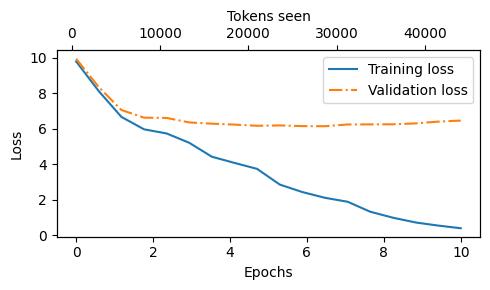

In [34]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
    epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.plot(tokens_seen, train_losses, alpha=0)
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, token_seen, train_losses, val_losses)

- both training and validate improve at the 1st epoch
- but start to diverge past the 2nd epoch
- overfitting!! model is just memorizing text from the sample!
- exepected due to small training set with multiple epoch!
    - usually is large training set and 1 epoch only

## 5.3 Decoding strategies to control randomness
- known as "generation strategies" also

In [35]:
model.to("cpu") # move from GPU to CPU, as inference with small model does not require GPU
model.eval() # turn off random component

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [36]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model, # plug the model into generate_text_simple
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was one of the axioms he laid down across the Sevres and silver of an exquisitely appointed lun


- generated token is selected for the largest probability score
- means LLM will always generate same output even  `generate_text_simple` run multiple time

### 5.3.1 Temperature scaling
- temperature scaling: add probabilistic selection process to next-token generation task
- `torch.argmax`: select highest probability, greedy decoding
 

In [37]:
vocab = {
 "closer": 0,
 "every": 1,
 "effort": 2,
 "forward": 3,
 "inches": 4,
 "moves": 5,
 "pizza": 6,
 "toward": 7,
 "you": 8,
}
inverse_vocab = {v: k for k, v in vocab.items()}

# assume beow is LLM generated
next_token_logits = torch.tensor(
 [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [38]:
probas = torch.softmax(next_token_logits, dim=0) # convert logits into probability using softmax
next_token_id = torch.argmax(probas).item() # get token id correspond to the argmax
print(inverse_vocab[next_token_id])

forward


In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
# change from argmx to multinomial
print(inverse_vocab[next_token_id])

forward


In [40]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


- the word `forward` is sampled most but not always
- use temperature scaling to control distribution and selection process

In [41]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# temperature >1: more uniformly distributed token probabilities
# temperature <1: more confident (sharper) distribution

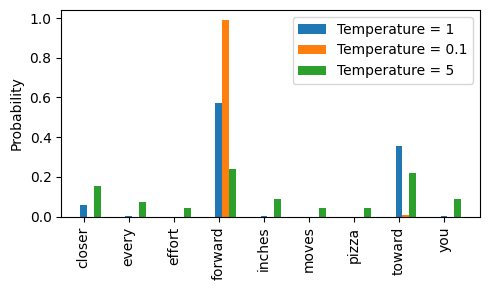

-----------temperature: 1-----------
73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
-----------temperature: 0.1-----------
0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
-----------temperature: 5-----------
165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


In [46]:
temperatures = [1, 0.1, 5]
scaled_probas = [softmax_with_temperature(next_token_logits, T)
    for T in temperatures]
x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i],
        bar_width, label=f'Temperature = {T}')
ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()
plt.tight_layout()
plt.show()
for t,k in zip(temperatures,scaled_probas):
    print(f'-----------temperature: {t}-----------')
    print_sampled_tokens(k)

### 5.3.2 Top-k sampling
- temperature scaling is good, can result in more diverse output, creative 
- but can cause grammatically incorrect  or totally nonsense sentence!
- use top-k sampling to restrict sampled token to the top-k most likely token
- all non-selected logits will be replace by `-inf` ( similar to mask them)
    - softmax will then apply ( and sum to 1)


In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k) # get the topk
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [48]:
# use where to set logit that below lowest to -inf
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float('-inf')),
    other=next_token_logits
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [49]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 Modifying the text generation function
- add temperature scaling and top-k sampling to modify `generate_text_simple`

In [ ]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None: # filter topk if needed
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
            logits < min_val,
            torch.tensor(float('-inf')).to(logits.device),
            logits
            )
        if temperature > 0.0: # apply temperature scaling
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)
        if idx_next == eos_id:
            break
        idx = torch.cat((idx, idx_next), dim=1)
    return idx

In [51]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you stand to work on surprise, a one of us had gone with random-


## 5.4 Loading and saving model weights in PyTorch
- pretrain LLM is expensive!
- can save and load

In [ ]:
torch.save(model.state_dict(), "model.pth")
# save model's state dict
# it is a dictionary mapping each layer to its parameter
# .pth is convetion for PyTorch files
# actaully can use any file extension haha

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval() # disabled the dropout for inference

# load the model

In [55]:
torch.save({
    "model_state_dict": model.state_dict(), # save state dict
    "optimizer_state_dict": optimizer.state_dict(), # the optimizer state need to save also if planed to continue pretraining
    },
    "model_and_optimizer.pth"
)

# AdamW store additional parameter for each model weight, and historical data are used to adjust learning rate for each model param
# without AdamW, the optimizer reset, and model cant learn well or even fail to converge

In [ ]:
# load model and optimizer
checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.5 Loading pretrained weights from OpenAI


In [57]:
import urllib.request
url = (
 "https://raw.githubusercontent.com/rasbt/"
 "LLMs-from-scratch/main/ch05/"
 "01_main-chapter-code/gpt_download.py"
)
filename = url.split('/')[-1]
urllib.request.urlretrieve(url, filename)
# downloasd the gpt_download.py, to download the GPT-2 weight by OPENAI

('gpt_download.py', <http.client.HTTPMessage at 0x2e11b379070>)

In [58]:
from gpt_download import download_and_load_gpt2
settings, params = download_and_load_gpt2(
 model_size="124M", models_dir="gpt2"
)

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 54.7kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 567kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 30.1kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [01:11<00:00, 7.00MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 2.61MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 467kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 320kiB/s]  


In [ ]:
print("Settings:", settings) # store LLM architecture setting, similar to GPT_CONFIG_124M
print("Parameter dictionary keys:", params.keys()) # contain the actual actual weight tensors
# only print key due to print weight tooooo much!!

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [60]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


- this is the 124M model
- other like 355M, 774M, 1558M also available

<img src="pic4.png" width="600">

- after loading GPT-2 model weight into python, still need to transfer setting and params dictionary into GPTModel

In [61]:
model_configs = {
 "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
 "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
 "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
 "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# create a dictionary that lists difference between different GPT model size

In [62]:
model_name = "gpt2-small (124M)"
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

# load the smallest

In [63]:
NEW_CONFIG.update({"context_length": 1024})
# remember to update the token length!, we use 256 token length earlier

In [64]:
NEW_CONFIG.update({"qkv_bias": True})

# OpenAI use bias vector in multi-head attention to implement the query, key, value martix
# Bias vectot not commonly used any more as doesnt improve performance
# but since OpenAi pretrained with it, need to match the setting for consistency!

In [65]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval()

# use the updated config to init a new GPTModel!

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [ ]:
# a small utility to check if 2 tensors or array have same dimensions/shape
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [68]:
# load weights from params dictionary into GPTModel
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])): # iterate over each transformer block in model
        # use np.split to divide attention and bias weight into 3 equal parts, for query, key, value
        q_w, k_w, v_w = np.split((params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split((params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(gpt.trf_blocks[b].att.out_proj.weight, params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(gpt.trf_blocks[b].att.out_proj.bias, params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(gpt.trf_blocks[b].ff.layers[0].weight, params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(gpt.trf_blocks[b].ff.layers[0].bias, params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(gpt.trf_blocks[b].ff.layers[2].weight, params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(gpt.trf_blocks[b].ff.layers[2].bias, params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(gpt.trf_blocks[b].norm1.scale, params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(gpt.trf_blocks[b].norm1.shift, params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(gpt.trf_blocks[b].norm2.scale, params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(gpt.trf_blocks[b].norm2.shift, params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])
    # GPT-2 used weight tying, to reuse the token embedding weights in output layer to reduce parameter number

- some difference:
    - OpenAI store weight tensor for output projection layer for first transformer block as:
        `params["blocks"][0]["attn"]["c_proj"]["w"]`
    - and in our model, it is:
        `gpt.trf_blocks[0].att.out_proj.weight`
    - need soem guesswork since naming convention difference, but the `assign` will warn us if trying to match 2 tensor with different dimensions

In [69]:
load_weights_into_gpt(gpt, params)
gpt.to(device)

# load weight into GPT!

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [ ]:
torch.manual_seed(123)
token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on top of that?


